<a href="https://colab.research.google.com/github/IamShivamJaiswal/TrafficSignClassifer/blob/master/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
f = open("cookie.txt",'w')
f.write("""
Paste here cookie 
""")
f.close()

How to download Kaggle dataset from command line?[Use this link](https://wdeback.gitlab.io/post/2018-03-08-how-to-download-kaggle-dataset-from-command-line/)

In [6]:
!wget -x -c --load-cookies cookie.txt https://www.kaggle.com/mahadevkonar/belgiumts-dataset/downloads/belgiumts-dataset.zip/1   -O belgiumts-dataset.zip

--2019-01-14 08:07:56--  https://www.kaggle.com/mahadevkonar/belgiumts-dataset/downloads/belgiumts-dataset.zip/1
Resolving www.kaggle.com (www.kaggle.com)... 23.96.207.25
Connecting to www.kaggle.com (www.kaggle.com)|23.96.207.25|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/kaggle-datasets/10902/15203/belgiumts-dataset.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1547712476&Signature=Rhn7qZyOlm8MqwXETXkZpg6sns%2FHAIl8yMwM%2BBPkNQRnrPjuRTkMrFhQqCA9dglmAljb3PCkN7zWb%2Fx9JAzlQLdCCeJ6Jc53lB%2B%2BI9qPvcRka3BGSzlmU%2BrqKdAEI%2Fal9RxW%2BdZzjxUikc23slETVr4onyaHutkubgv%2F64KEU%2FB%2BhRBvbHV3HH5XAlhC4BMb%2F3h30pNq4hXio1j6K%2B%2B6S7RGj%2Fm4prXFbhMxW%2Fdyy8sq9AXJltUMeDqQU7AVgDULQK%2FGfEOac2kzwKWKuSccvZWnHqGjo2a9SSgjwBwoPpbrzeu6l9mWd50AIximzrgfYcafH%2F5eaLkA2WD1VHb98g%3D%3D [following]
--2019-01-14 08:07:56--  https://storage.googleapis.com/kaggle-datasets/10902/15203/belgiumts-dataset.zip?GoogleAccessId=w

In [7]:
!unzip belgiumts-dataset.zip
!unzip BelgiumTSC_Testing.zip  -d data
!unzip BelgiumTSC_Training.zip  -d data


Archive:  belgiumts-dataset.zip
  inflating: BelgiumTSC_Training.zip  
  inflating: BelgiumTSC_Testing.zip  
Archive:  BelgiumTSC_Testing.zip
   creating: data/Testing/
   creating: data/Testing/00000/
  inflating: data/Testing/00000/00017_00000.ppm  
  inflating: data/Testing/00000/00017_00001.ppm  
  inflating: data/Testing/00000/00017_00002.ppm  
  inflating: data/Testing/00000/00021_00000.ppm  
  inflating: data/Testing/00000/00021_00001.ppm  
  inflating: data/Testing/00000/00021_00002.ppm  
  inflating: data/Testing/00000/GT-00000.csv  
   creating: data/Testing/00001/
  inflating: data/Testing/00001/00252_00000.ppm  
  inflating: data/Testing/00001/00252_00001.ppm  
  inflating: data/Testing/00001/00252_00002.ppm  
  inflating: data/Testing/00001/00398_00000.ppm  
  inflating: data/Testing/00001/00398_00001.ppm  
  inflating: data/Testing/00001/00398_00002.ppm  
  inflating: data/Testing/00001/00414_00000.ppm  
  inflating: data/Testing/00001/00414_00001.ppm  
  inflating: data/

In [8]:
!cd data && ls

Testing  Training


In [9]:
import numpy as np
import pandas as pd

# imports needed for CNN
import csv
import cv2
import os, glob
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import time
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt

from subprocess import check_output

Using TensorFlow backend.


In [0]:
def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = os.listdir(data_dir)
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    category = 0
    for d in directories:
        if (d != 'Readme.txt'):
            file_names = [os.path.join(data_dir + d, f) for f in os.listdir(data_dir + d) if f.endswith(".ppm")]
        else:
            continue
        for f in file_names:
            img = cv2.imread(f)
            imresize = cv2.resize(img, (200, 125))
            #plt.imshow(imresize)
            images.append(imresize)
            labels.append(category) 
        category += 1
    #Normalization
    images = np.array(images).astype('float32')
    images = images / 255.0
    #hot encoding
    labels = np.array(labels)
    labels = to_categorical(labels,category)
    return images, labels

In [11]:
X_train, y_train = load_data('data/Training/')
print (len(X_train))
print (len(y_train))

4575
4575


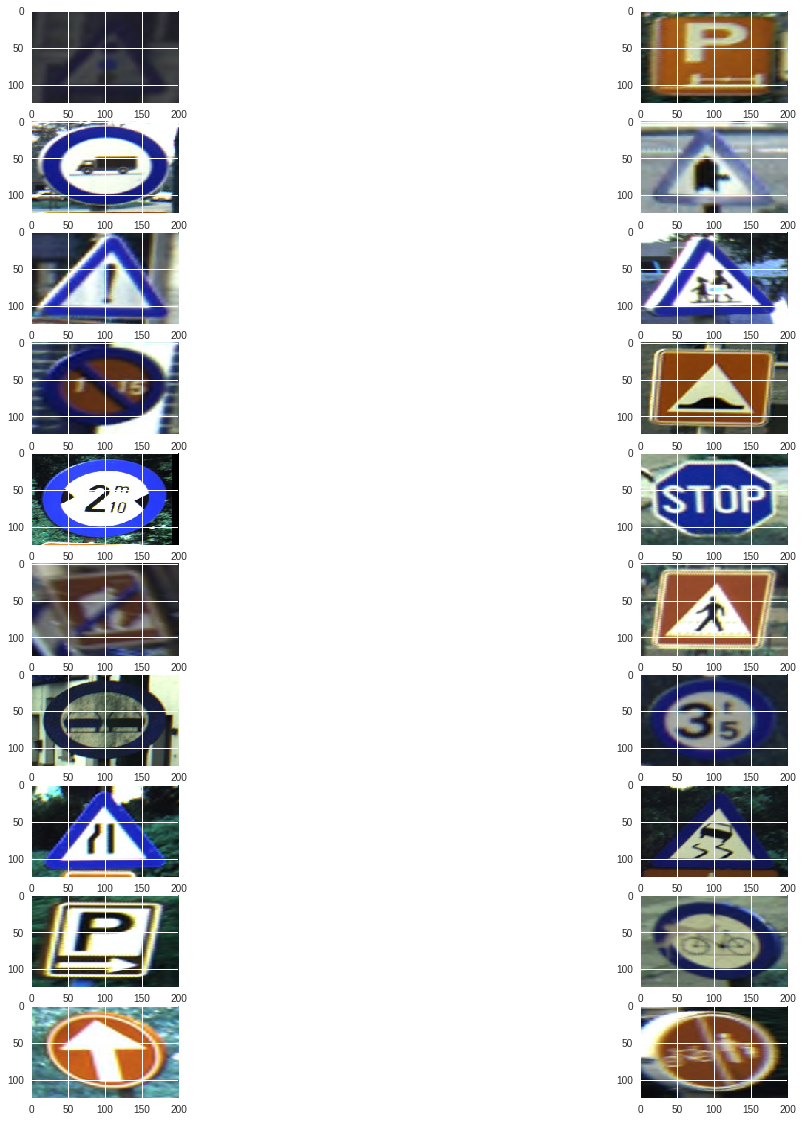

In [12]:
temp = -1
fig=plt.figure(figsize=(20, 20))
for i in range(0,y_train.shape[0]):
    if (np.argmax(y_train[i]) != temp):
        fig.add_subplot(10, 2, np.argmax(y_train[i]) + 1)
        plt.imshow(X_train[i])
        if (np.argmax(y_train[i]) >= 19):
            break
        temp = np.argmax(y_train[i])

In [13]:
X_test, y_test = load_data('data/Testing/')
print (len(X_test),len(y_test))

2520 2520


In [0]:
def createCNNModel(num_classes):
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=(125, 200, 3), border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    lrate = 0.01
    decay = lrate/30
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model

In [15]:
model = createCNNModel(y_train.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 200, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 100, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 98, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 49, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 23, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10304)             0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(125, 200,..., activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  import sys


In [16]:
model.fit(X_train, y_train, validation_split = 0.05, epochs=30)

Train on 4346 samples, validate on 229 samples
Epoch 1/30
4346/4346 [==============================] - 10s 2ms/step - loss: 2.7438 - acc: 0.3295 - val_loss: 4.7688 - val_acc: 0.3581
Epoch 2/30
4346/4346 [==============================] - 6s 1ms/step - loss: 0.9899 - acc: 0.7285 - val_loss: 7.9956 - val_acc: 0.3581
Epoch 3/30
4346/4346 [==============================] - 6s 1ms/step - loss: 0.4696 - acc: 0.8792 - val_loss: 8.2275 - val_acc: 0.3668
Epoch 4/30
4346/4346 [==============================] - 6s 1ms/step - loss: 0.2821 - acc: 0.9294 - val_loss: 8.9892 - val_acc: 0.3712
Epoch 5/30
4346/4346 [==============================] - 6s 1ms/step - loss: 0.1661 - acc: 0.9570 - val_loss: 9.0692 - val_acc: 0.3668
Epoch 6/30
4346/4346 [==============================] - 6s 1ms/step - loss: 0.0993 - acc: 0.9724 - val_loss: 9.4002 - val_acc: 0.3755
Epoch 7/30
4346/4346 [==============================] - 6s 1ms/step - loss: 0.0700 - acc: 0.9823 - val_loss: 9.6400 - val_acc: 0.3668
Epoch 8/30
434

In [17]:
predict = np.argmax(model.predict(X_test), axis = 1)
count = 0
for i in range(0,predict.shape[0]):
    if (predict[i] == np.argmax(y_test[i])):
        count +=1
print ('Accuracy on Test ',100 * count/predict.shape[0],'%')

Accuracy on Test  92.26190476190476 %
